In [1]:
%load_ext autoreload
%autoreload 2

# Neural network

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from re import search
from itertools import permutations
from sklearn.metrics import confusion_matrix, r2_score
import pickle

## Loading preprocessed data

In [3]:
X = np.loadtxt(open("../data/X.csv", "rb"), delimiter=",")
Y = np.loadtxt(open("../data/Y.csv", "rb"), delimiter=",")
with open('../data/X.colnames.txt', 'r') as file:
    line = file.readline().strip()
    col_names = line.split(',')

## Data Exploration

Predictors:

In [4]:
X.shape

(8210, 42)

Response:

In [5]:
Y.shape

(8210, 2)

Meanings for each column in X:

In [6]:
col_names

['Postfloodingorirrigatedcroplandsoaquatic',
 'Rainfedcroplands',
 'Mosaiccropland5070vegetationgrasslandshrublandforest2050',
 'Mosaicvegetationgrasslandshrublandforest5070cropland2050',
 'Closedtoopen15broadleavedevergreenorsemideciduousforest5m',
 'Closed40broadleaveddeciduousforest5m',
 'Open1540broadleaveddeciduousforestwoodland5m',
 'Closed40needleleavedevergreenforest5m',
 'Open1540needleleaveddeciduousorevergreenforest5m',
 'Closedtoopen15mixedbroadleavedandneedleleavedforest5m',
 'Mosaicforestorshrubland5070grassland2050',
 'Mosaicgrassland5070forestorshrubland2050',
 'Closedtoopen15broadleavedorneedleleavedevergreenordeciduousshrubland5m',
 'Closedtoopen15herbaceousvegetationgrasslandsavannasorlichensmosses',
 'Sparse15vegetation',
 'Closedtoopen15broadleavedforestregularlyfloodedsemipermanentlyortemporarilyFreshorbrackishwater',
 'Closed40broadleavedforestorshrublandpermanentlyfloodedSalineorbrackishwater',
 'Closedtoopen15grasslandorwoodyvegetationonregularlyfloodedorwaterl

3 of them are hot encoded Metabolism:

In [7]:
[(i,col_names[i]) for i in range(len(col_names)) if search("Metabolism", col_names[i])]

[(34, 'Metabolism_ectotherm'),
 (35, 'Metabolism_endotherm'),
 (36, 'Metabolism_photosynthesis')]

And 5 of them are hot encoded Habit:

In [8]:
[(i,col_names[i]) for i in range(len(col_names)) if search("Habit", col_names[i])]

[(37, 'Habit_aquatic'),
 (38, 'Habit_parasitic'),
 (39, 'Habit_terrestrial'),
 (40, 'Habit_transitional'),
 (41, 'Habit_winged')]

## Build neural network regressor

Here I used `MLPRegressor` from `sklearn.neural_network` to build neural network.

### Find best number of layers and neurons through grid search

As there are 42 predictors, and 8 of them are hot encoded by 2 variables, here I set the maximum number of neurons each layer can have to 36, and maximum number of layer to 4 and minimum number of neurons to be 4.

In [9]:
def generate_nn_configs(max_layers, max_neurons, step = 1, min_neurons = 4):
    configs = []
    for l in range(1, max_layers+1):
        if l == 1:
            configs.extend([(x) for x in range(min_neurons, max_neurons + 1, step)])
        else:
            configs.extend([x for x in permutations(range(min_neurons, max_neurons + 1, step), l)])
    return configs

Increment is set to 4 otherwise there are too many configurations. Check the total number of neural networks compared.

In [10]:
hidden_layer_configs = generate_nn_configs(max_layers = 3,
                                           max_neurons = 36,
                                           step = 4,
                                           min_neurons = 4)
len(hidden_layer_configs)

585

The grid search is in `gridSearchLayerNeuron.py`. The criteria is 3-fold CV. The results has been generated and saved to `grid_result`.

In [11]:
#! python gridSearchLayerNeuron.py

Loading the result and print the best number of layers and neurons. The best model is NN with 3 layers and 4, 8, 36 neurons each layer.

In [12]:
with open('grid_result', 'rb') as grid_result_file:
    grid_result = pickle.load(grid_result_file)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.175989 using {'hidden_layer_sizes': (4, 8, 36)}


Get the trained model and check the learning curve:

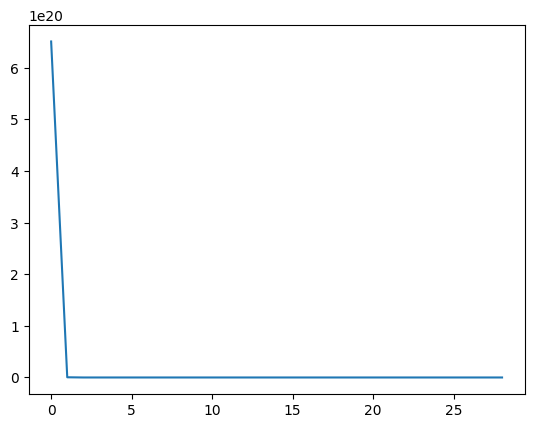

In [13]:
reg = grid_result.best_estimator_
plt.plot(reg.loss_curve_)

### Check the "Accuracy" of model

Just for comparison, although I used p-value as response for the neural network,
here I transformed the true and predicted p-value by a threshold of `0.05` and
calculate the confusion matrix.

In [14]:
# because p-values of IBD and IBE are referring to 2 hypotheses,
# The confusion matrix is built on IBD and IBE individually
# The function will build a confusion matrix for each column
def confusion_matrix_list(Y, Y_hat):
    Y_labeled = Y <= 0.05
    Y_hat_labeled = Y_hat <= 0.05

    N, D = Y_labeled.shape
    cm = []
    for d in range(D):
        Y_labeled_d = Y_labeled[:,d]
        Y_hat_labeled_d = Y_hat_labeled[:,d]
        cm.append(confusion_matrix(Y_labeled_d, Y_hat_labeled_d, normalize = "true", labels= [True, False]))
    return cm

In [15]:
confusion_matrix_list(Y, reg.predict(X))

[array([[0.00183066, 0.99816934],
        [0.00165975, 0.99834025]]),
 array([[0.00327332, 0.99672668],
        [0.00125451, 0.99874549]])]

Unfortunately although training set has been balanced (see `gridSearchLayerNeuron.py`), the false negative rate is still extremely high.
I will proceed the analysis, but keep in mind that the NN trained is undertrained.

## Importance analysis

In [16]:
## Util function
## Given X and index of columns to be permuted
## Return permuted X with columns permuted TOGETHER,
## This is because hot encoded columns should only have one 1 per row
## Permuting each column individually does not work for hot encoded columns
def permute_column(X, cols):
    X_new = X.copy()
    X_new[:,cols] = np.random.permutation(X_new[:,cols])
    return X_new

## Peform importance analysis by permutation test
## Return the mean decrease of correlation between predicted Y and true Y
## Per column or column set (hot encoded columns)
def importance(reg, cols_list, X, Y, nPerm = 100):
    imps = []
    for cols in cols_list:
        scores = [[r2_score(Y[:,0], reg.predict(permute_column(X, cols))[:,0]),
                   r2_score(Y[:,1], reg.predict(permute_column(X, cols))[:,1])] for i in range(nPerm)]
        mean_scores = np.mean(scores, axis = 0)
        imps.append(mean_scores)

    return imps

Perpare a column list, each element is a list of column(s).

In [17]:
cols_list = [[x] for x in range(34)]
cols_list.append([34, 35, 36])
cols_list.append([37, 38, 39, 40, 41])

Perform the analysis

In [18]:
imps_permutation = importance(reg, cols_list, X, Y, 3)

Prepare the name of columns. Recall that column 34-36 are hot encoded metabolism and 37-41 are hot encoded habit

In [19]:
var_names = col_names[0:34]
var_names.append("Metabolism")
var_names.append("Habit")

Attach names to mean decrease correlation

In [20]:
imp_original = [r2_score(Y[:,0], reg.predict(X)[:,0]),
                r2_score(Y[:,1], reg.predict(X)[:,1])]
imp_decrease = [list(imp_original - imps_permutation[i]) for i in range(len(imps_permutation))]
imp_decrease = np.array(imp_decrease)

Show variables that have top 5 mean decrease correlation of IBD

In [21]:
sorted(zip(var_names, imp_decrease[:,0], imp_decrease[:,1]), key = lambda x: x[1], reverse=True)[0:5]

[('min_lon', 0.02918962297472194, 0.035510337567239036),
 ('max_lon', 0.028906181329495212, 0.046906361732080126),
 ('area', 0.013072665926972649, 0.034563848770119254),
 ('elevation_mean', 0.01205393265187285, 0.015657339706638407),
 ('abs_mid_lat', 0.006413904804573128, 0.005176871537975858)]

Show variables that have top 5 mean decrease correlation of IBE

In [22]:
sorted(zip(var_names, imp_decrease[:,0], imp_decrease[:,1]), key = lambda x: x[2], reverse=True)[0:5]

[('max_lon', 0.028906181329495212, 0.046906361732080126),
 ('min_lon', 0.02918962297472194, 0.035510337567239036),
 ('area', 0.013072665926972649, 0.034563848770119254),
 ('elevation_mean', 0.01205393265187285, 0.015657339706638407),
 ('min_lat', 0.0021908512833261062, 0.00877845562464602)]